In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=True,
    transform=transform)
print(' Number of training data ', len(trainset))

 Number of training data  60000


In [5]:
test_set = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=False,
    transform=transform)
print(' Number of testing data ',len(test_set))

 Number of testing data  10000


In [6]:
train_set, val_set = torch.utils.data.random_split(trainset, [50000, 10000])
print(' Number of final training data ', len(train_set))
print(' Number of validation data ', len(val_set))

 Number of final training data  50000
 Number of validation data  10000


In [7]:
BATCH_SIZE = 256

In [8]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [9]:
validationloader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

In [10]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [11]:
cnn_layers =  nn.Sequential(
            # Defining a 2D convolution layer
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            # in_channels (int) – Number of channels in the input image. For B&W it is 1.
            # out_channels (int) – Number of channels produced by the convolution. 4 filters
            # kernel_size (int or tuple) – Size of the convolving kernel (3x3)
            # stride (int or tuple, optional) – Stride of the convolution
            # padding (int or tuple, optional) – Padding of 1 added to both sides of the input
            # example x1 = (n, c=1 , h=28 , w=28 )
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1), #in_channels = 1 is a data dependent hyperparameter. It is 1 because the images are in grayscale
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.BatchNorm2d(4), # Normalize output from the activation function. 
            nn.ReLU(inplace=True), # negative elements to zero
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.MaxPool2d(kernel_size=2, stride=2), #Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on
            # x3 = (n, c=4 , h=14 , w=14 )
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.BatchNorm2d(4), # 4 features
            nn.ReLU(inplace=True), # inplace = True will modify the input directly, without allocating any additional output.
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.MaxPool2d(kernel_size=2, stride=2), # Downsamples the input representation by taking the maximum value
            # x4 = (n, c=4 , h=7 , w=7 )
        )
        # outputSize = floor[(inputSize - filterSize + 2 * padding) / stride] + 1
print(cnn_layers)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [12]:
linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 10) 
#10 outputs because MNIST Fashion has 10 different classes. It is a data dependent hyperparameter

)

print(linear_layers)

Sequential(
  (0): Linear(in_features=196, out_features=10, bias=True)
)


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layer = cnn_layers
        self.linear_layer = linear_layers
    
    def forward(self, x):
        x = self.cnn_layer(x)
        x = x.view(x.shape[0],-1)
        x = self.linear_layer(x)
        return x

In [14]:
net = Net()

In [15]:

optimizer =  optim.Adam(net.parameters(), lr=0.07) # learning rate 
# defining the loss function
criterion =  nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    print('cuda is available')
    net = net.cuda()
    criterion = criterion.cuda()

cuda is available


In [16]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([256, 1, 28, 28])


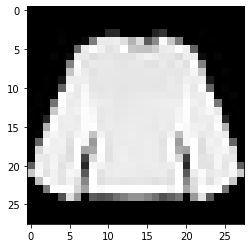

In [17]:
import numpy as np
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)), cmap='gray')

<Figure size 432x288 with 0 Axes>

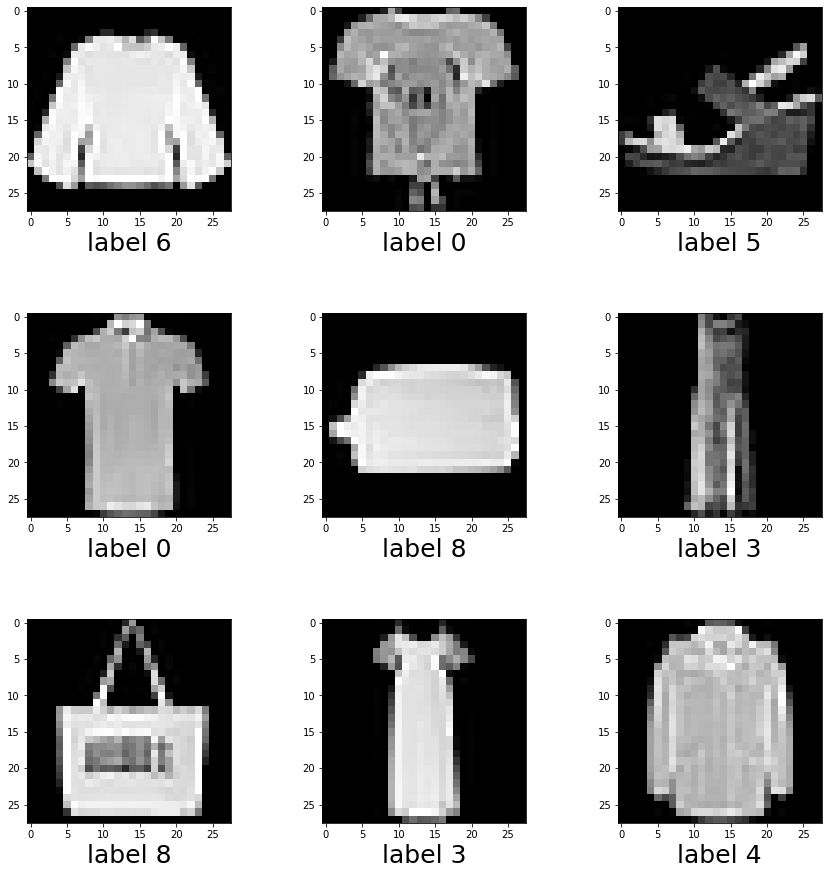

In [18]:
plt.figure()
plt_row = 3
plt_col = 3
fig, axes = plt.subplots(plt_row, plt_col, figsize=(15,15))
plt.subplots_adjust( hspace=0.5)
counter = 0
for i in range(plt_row):
    for j in range(plt_col):
        image = np.transpose(images[counter].numpy(), (1, 2, 0))
        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_xlabel("label {label}".format(label = labels[counter]),fontsize=25 )
        counter = counter + 1
plt.show()

In [19]:
def accuracy_finder(predictions , labels):
    softmax = torch.nn.Softmax(dim=1) 
    predictions = softmax(predictions)
    values, max_indices = torch.max(predictions, dim=1) 
    accuracy = ( max_indices == labels ).sum().item()/max_indices.size()[0]
    return accuracy

In [40]:
def validate():
    batches_traversed = 0 
    total_val_accuracy = 0
    total_val_loss = 0 
    for i, data in enumerate(validationloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        with torch.no_grad():
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_val_loss = total_val_loss + loss.item()
            val_accuracy = accuracy_finder(predictions=outputs, labels=labels)
        total_val_accuracy = total_val_accuracy + val_accuracy
        batches_traversed = batches_traversed + 1
    return (total_val_loss/batches_traversed, total_val_accuracy/batches_traversed)

In [56]:
def train(epochs:int):
    all_training_losses = []
    all_training_acc = []
    all_validation_losses = []
    all_validation_acc = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        targets = []
        total_loss_epoch = 0
        total_acc_epoch = 0
        batches_traversed = 0 
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            targets.append(labels)
            total_loss_epoch = total_loss_epoch + loss.item()
            training_accuracy = accuracy_finder(predictions=outputs, labels=labels)
            total_acc_epoch = total_acc_epoch + training_accuracy
            batches_traversed = batches_traversed + 1 
        all_training_losses.append(total_loss_epoch/batches_traversed)
        all_training_acc.append(total_acc_epoch/batches_traversed)
        val_loss, val_acc = validate()
        all_validation_losses.append(val_loss)
        all_validation_acc.append(val_acc)
        print("epoch : {}, training loss : {}, training accuracy {},  validation loss : {}, validation accuracy {}".format(epoch+1,round((total_loss_epoch/batches_traversed),3),round((total_acc_epoch/batches_traversed),3), round(val_loss,3), round(val_acc,3)))
    print('Finished Training')
    return (all_training_losses, all_training_acc, all_validation_losses, all_validation_acc)

In [57]:
training_loss, training_acc, val_loss, val_acc = train(epochs=50)

epoch : 1, training loss : 0.393, training accuracy 0.861,  validation loss : 0.414, validation accuracy 0.856
epoch : 2, training loss : 0.386, training accuracy 0.862,  validation loss : 0.421, validation accuracy 0.854
epoch : 3, training loss : 0.379, training accuracy 0.867,  validation loss : 0.408, validation accuracy 0.855
epoch : 4, training loss : 0.377, training accuracy 0.866,  validation loss : 0.424, validation accuracy 0.851
epoch : 5, training loss : 0.377, training accuracy 0.867,  validation loss : 0.395, validation accuracy 0.86
epoch : 6, training loss : 0.371, training accuracy 0.867,  validation loss : 0.421, validation accuracy 0.854
epoch : 7, training loss : 0.372, training accuracy 0.867,  validation loss : 0.415, validation accuracy 0.854
epoch : 8, training loss : 0.372, training accuracy 0.867,  validation loss : 0.399, validation accuracy 0.863
epoch : 9, training loss : 0.369, training accuracy 0.869,  validation loss : 0.402, validation accuracy 0.861
ep

In [58]:
PATH = './fmnist_test.pth'
#saving model
torch.save(net.state_dict(), PATH)

In [59]:
print(len(training_loss))
print(len(training_acc))
print(len(val_loss))
print(len(val_acc))

50
50
50
50


In [60]:
def convert_to_tensor_from_list_of_tensors(values):
    try:
        try: 
            values = torch.cuda.FloatTensor(values)
        except: 
            values = torch.FloatTensor(values)
    except: 
        print('an exception occured')
    return values

In [61]:
loss = convert_to_tensor_from_list_of_tensors(training_loss)
acc = convert_to_tensor_from_list_of_tensors(training_acc)
v_loss = convert_to_tensor_from_list_of_tensors(val_loss) 
v_acc = convert_to_tensor_from_list_of_tensors(val_acc)
print(loss)
print(acc)
print(v_loss)
print(v_acc)

tensor([0.3926, 0.3864, 0.3785, 0.3768, 0.3770, 0.3713, 0.3721, 0.3718, 0.3691,
        0.3663, 0.3721, 0.3719, 0.3680, 0.3681, 0.3627, 0.3726, 0.3649, 0.3667,
        0.3673, 0.3615, 0.3632, 0.3652, 0.3608, 0.3664, 0.3597, 0.3634, 0.3612,
        0.3637, 0.3553, 0.3644, 0.3612, 0.3594, 0.3600, 0.3586, 0.3574, 0.3647,
        0.3557, 0.3627, 0.3539, 0.3609, 0.3573, 0.3540, 0.3538, 0.3563, 0.3569,
        0.3573, 0.3543, 0.3544, 0.3544, 0.3627], device='cuda:0')
tensor([0.8606, 0.8625, 0.8668, 0.8660, 0.8668, 0.8674, 0.8674, 0.8669, 0.8689,
        0.8682, 0.8664, 0.8664, 0.8672, 0.8692, 0.8699, 0.8673, 0.8717, 0.8701,
        0.8688, 0.8707, 0.8711, 0.8705, 0.8724, 0.8704, 0.8726, 0.8712, 0.8711,
        0.8697, 0.8739, 0.8704, 0.8725, 0.8732, 0.8731, 0.8722, 0.8727, 0.8697,
        0.8742, 0.8709, 0.8741, 0.8713, 0.8730, 0.8733, 0.8751, 0.8729, 0.8728,
        0.8739, 0.8737, 0.8731, 0.8737, 0.8730], device='cuda:0')
tensor([0.4137, 0.4209, 0.4084, 0.4240, 0.3949, 0.4211, 0.4153, 0.39

In [62]:
def acc_and_loss_plot(accuracy, loss,title):
    loss_plot = loss.cpu().numpy()
    acc_plot = acc.cpu().numpy()
    plt.plot(loss_plot,'r', label="loss")
    plt.plot(acc_plot,'b', label="validation")
    plt.title(title)
    plt.legend(("loss","accuracy"))
    plt.xlabel("epochs")
    plt.show()

In [75]:
def result_plot(v_value , t_value, title,ylabel):
    v_value = v_value.cpu().numpy()
    t_value = t_value.cpu().numpy()
    plt.plot(v_value,'r')
    plt.plot(t_value,'b')
    plt.title(title)
    plt.legend(("validation","training"))
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.show()

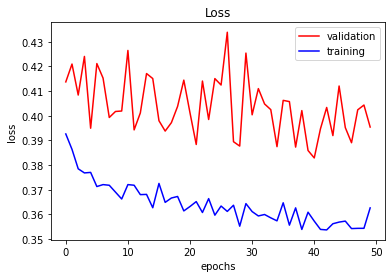

In [76]:
result_plot(v_value= v_loss ,t_value= loss, title="Loss", ylabel="loss" )

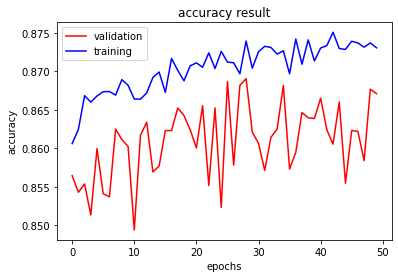

In [77]:
result_plot(v_value= v_acc ,t_value= acc,title="accuracy result", ylabel="accuracy")

In [112]:
values, ind = torch.max(output, dim=1)
print(ind)
values, ind = torch.max(pred, dim = 1)
print(ind.size())

tensor([4, 0, 8, 7, 6, 8, 9, 3, 7, 3, 9, 2, 4, 4, 3, 9, 2, 9, 4, 9, 0, 5, 5, 4,
        7, 0, 5, 8, 0, 2, 5, 9, 8, 0, 0, 8, 4, 3, 5, 2, 3, 4, 5, 2, 1, 3, 5, 4,
        5, 4, 4, 0, 7, 1, 5, 1, 0, 9, 7, 9, 5, 8, 3, 3, 0, 1, 7, 4, 8, 4, 7, 4,
        8, 9, 0, 0, 3, 7, 6, 4], device='cuda:0')
torch.Size([50000])


In [63]:
print(outputs[1])
print(torch.max(outputs[0]))
torch.topk(outputs,k=2, dim=1)

tensor([ 0.4464,  0.1405, -0.3777, -0.0677,  0.0247,  0.1026, -0.5148,  0.2474,
         0.2994,  0.1011], device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4464, device='cuda:0', grad_fn=<MaxBackward1>)


torch.return_types.topk(
values=tensor([[0.4464, 0.2994],
        [0.4464, 0.2994],
        [0.4464, 0.2994],
        [0.4464, 0.2994]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[0, 8],
        [0, 8],
        [0, 8],
        [0, 8]], device='cuda:0'))

In [19]:
PATH = './fmnist_test.pth'
torch.save(net.state_dict(), PATH)

In [78]:
loadNet = Net()
loadNet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [79]:
print(loadNet)

Net(
  (cnn_layer): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


<generator object Module.children at 0x000002613A214BA0>
torch.Size([4, 1, 3, 3])


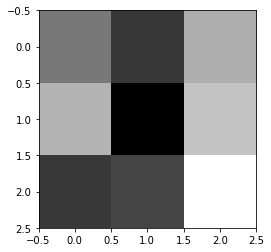

In [80]:
model_children = loadNet.children()
print(model_children)
filters = list(model_children)[0][0].weight
print(filters.shape)
plt.imshow(np.transpose(filters[0].cpu().detach().numpy(), (1, 2, 0)), cmap='gray')